# Task 1
Train a CNN network from scratch using the given [dataset](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip). 

Instructions:
- use no other dataset or pretrained model
- explain design choices during preprocessing, model building and training
- cite sources used
- save model checkpoints

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 7.2MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten, InputLayer

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Modified MNIST/train/'
CKPT_PATH = '/content/drive/MyDrive/Modified MNIST/checkpoints/ckpts-1/'

IMAGE_SHAPE = (64, 64, 3)
BATCH_SIZE = 128
NUM_CLASSES = 62
LEARNING_RATE = 5e-4
NUM_EPOCHS = 200

## Data Loader

The `DataLoader()` loads, preprocesses, and returns a batch of images on the fly.

The following preprocessings are used:

- For validating the model's performance, an `80-20 train-val split` is made from the training dataset.
- The images are `reshaped to 64 x 64 x 3`.
- The images are `normalized to [0, 1]` by dividing each pixel value by 255.
- Since number of samples per class is small, data augmentation is used to synthetically increase the dataset's size. The augmentations are selected so as to ensure that they don't alter the underlying data distribution. For example, random flip cannot be used as it will mislead the model by changing 'p' to 'q', 'b' to 'd', '6' to '9', etc.
The following data augmentation techniques are used:
 - `random rotation` - rotates the images by atmost 20 degrees in clockwise or counter-clockwise direction.
 - `random central crop` - crops out the center part of the images. We use center crop instead of random crop because the numbers and letters are written in the center of the image. Randomly cropping the images can potentially mislead the model by converting 'U' to 'L', 'd' to 'c', '0' to 'C', '0' to 'u', etc.
 - `brightness adjustment` - slightly alters the brightness level of the images.
- The colours in the images are `inverted`, i.e., black is converted into white and vice-versa. This is done to maintain consistency with the MNIST dataset and the task 3 dataset.


In [ ]:
class DataLoader():
  '''
    A class to fetch data for training and testing

    utilities:
      1. parse()
      2. get_ds_train()
      3. get_ds_dev()
      4. plot_samples()
  '''

  def __init__(self, path, image_shape, batch_size):
    ''' Generates a list of images and their corresponding labels '''

    path = path
    x_list = []
    y_list = []
    self.image_height = image_shape[0]
    self.image_width = image_shape[1]
    self.batch_size = batch_size

    for subdir, dirs, files in os.walk(path):
      for f in files:
        image_path = os.path.join(subdir, f)
        label = int(image_path.split('/')[6][-2:])
        x_list.append(image_path)
        y_list.append(label)
    
    self.x_train, self.x_dev, self.y_train, self.y_dev = train_test_split(x_list, 
                                                                          y_list, 
                                                                          test_size = 0.2, 
                                                                          random_state = 1)
    self.mode = 'test'

  def parse(self, image_path, label):
    ''' Reads and preprocesses images, and converts labels into one-hot encodings '''

    def augment(image, label):
      image = tfa.image.rotate(image, 
                               0.01744 * np.random.uniform(-20.0, 20.0),
                               fill_mode = 'nearest')
      
      h, w, c = image.shape
      x = int(np.random.uniform(0.0, 0.2) * h)
      y = int(np.random.uniform(0.0, 0.2) * w)
      image = image[x:(h - x), y:(w - y), :]
      image = np.pad(image, ((x, x), (y, y), (0, 0)), constant_values = 255)
      return image, label

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels = 3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [self.image_height, self.image_width])
    if self.mode == 'train':
      image, label = tf.py_function(augment, [image, label], [tf.float32, tf.int32])
      image.set_shape((self.image_height, self.image_width, 3))
      label.set_shape(())
      image = tf.image.random_brightness(image, max_delta = 0.5)
    image = image / 255.
    image = tf.clip_by_value(image, 0.0, 1.0)
    image = 1 - image
    label -= 1
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

  def get_ds_train(self):
    ''' Returns training dataset '''

    BUFFER_SIZE = len(self.x_train)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    self.mode = 'train'
    ds = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
    ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.map(self.parse, num_parallel_calls = AUTOTUNE)
    ds = ds.batch(self.batch_size)
    ds = ds.prefetch(BUFFER_SIZE)
    return ds

  def get_ds_dev(self):
    ''' Returns dev dataset '''

    BUFFER_SIZE = len(self.x_dev)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    self.mode = 'test'
    ds = tf.data.Dataset.from_tensor_slices((self.x_dev, self.y_dev))
    ds = ds.map(self.parse, num_parallel_calls = AUTOTUNE)
    ds = ds.batch(self.batch_size)
    ds = ds.prefetch(BUFFER_SIZE)
    return ds
  
  def plot_samples(self, ds, max = 10):
    ''' Plots samples of images from 'ds' '''

    count = 1
    plt.figure(figsize = (max, 5))
    for x, y in ds:
      for image, label in zip(x, y):
        plt.subplot(max // 5, 5, count)
        plt.imshow(image)
        plt.axis('off')
        count += 1
        if count == max + 1:
          break
      break
    plt.show()

Training Samples:


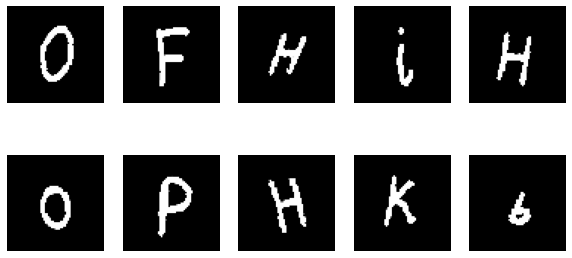


Validation Samples:


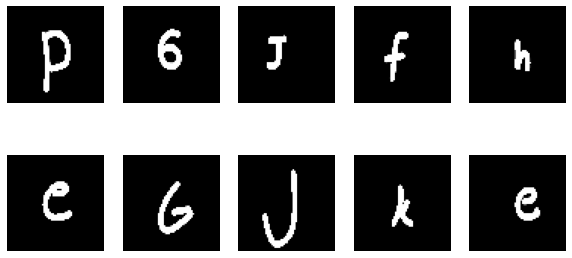

In [ ]:
dataloader = DataLoader(DATA_PATH, IMAGE_SHAPE, BATCH_SIZE)
ds_train = dataloader.get_ds_train()
ds_dev = dataloader.get_ds_dev()

print('Training Samples:')
dataloader.plot_samples(ds_train)
print('\nValidation Samples:')
dataloader.plot_samples(ds_dev)

## Model

The `Model()` class defines the architecture of the CNN model. Model subclassing is used to define the model architecture.

Design choice:
- convolution layers are used to extract feature representations from the feature maps
- maxpooling is used to reduce the height and width of the feature maps
- dropout is used to prevent overfitting


In [ ]:
class Model(tf.keras.Model):
  '''
    The class defining model's architecture

    utilities:
      1. __init__()
      2. call()
  '''

  def __init__(self, num_classes, input_shape):
    ''' Define the layers on the model '''

    super(Model, self).__init__()
    self.conv11 = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same',
                        activation = 'relu', input_shape = input_shape)
    self.conv12 = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same',
                        activation = 'relu')
    self.pool1 = MaxPool2D((2, 2))
    self.dropout1 = Dropout(0.25)

    self.conv21 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv22 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool2 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout2 = Dropout(0.25)

    self.conv31 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv32 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool3 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout3 = Dropout(0.25)

    self.conv41 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv42 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool4 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout4 = Dropout(0.25)

    self.conv51 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv52 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool5 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout5 = Dropout(0.25)

    self.flatten = Flatten()
    self.dense1 = Dense(256, activation = 'relu')
    self.dropout01 = Dropout(0.4)
    self.dense2 = Dense(128, activation = 'relu')
    self.dropout02 = Dropout(0.4)
    self.dense3 = Dense(num_classes)
  
  def call(self, x, training = True):
    ''' Forward propogation of input 'x' '''

    z = self.conv11(x)
    z = self.conv12(z)
    z = self.pool1(z)
    z = self.dropout1(z, training = training)

    z = self.conv21(z)
    z = self.conv22(z)
    z = self.pool2(z)
    z = self.dropout2(z, training = training)

    z = self.conv31(z)
    z = self.conv32(z)
    z = self.pool3(z)
    z = self.dropout3(z, training = training)

    z = self.conv41(z)
    z = self.conv42(z)
    z = self.pool4(z)
    z = self.dropout4(z, training = training)

    z = self.conv51(z)
    z = self.conv52(z)
    z = self.pool5(z)
    z = self.dropout5(z, training = training)

    z = self.flatten(z)
    z = self.dense1(z)
    z = self.dropout01(z, training = training)

    z = self.dense2(z)
    z = self.dropout02(z, training = training)

    z = self.dense3(z)
    return z

In [ ]:
model = Model(NUM_CLASSES, IMAGE_SHAPE)

## Training

The `train()` function defines the training parameters, compiles the model and trains it. The following are the traininge parameters used:
- `RMSProp optimizer`
- `catergorical cross-entropy loss` - computes loss from logits returned by the model.
- `lr_scheduler` - reduces the learning rate by a factor of 0.9 when the val_accuracy does not increase for 7 epochs.
- `checkpoints` - monitors the val_accuracy and saves the weights of best model.

Hyperparameter and Parameter Tuning

- `learning_rate` - the following values of learning rates were tried: 1e-2, 1e-3, 5e-4, 1e-4, 1e-5. It was found that the model failed to converge with learning rates of 0.01 and 0.001, and the convergence was slow with 1e-4 and 1e-5. Thus, learning_rate of 5e-4 was finally selected.
- `optimizer` - adam, adamax and rmsprop were tried out.



In [ ]:
def train(model, ds_train, ds_dev, learning_rate, num_epochs, ckpt_path):
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                      patience = 7,  
                                                      verbose = 1, 
                                                      factor = 0.9, 
                                                      min_lr = 0.00001)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                                  monitor = 'val_accuracy',
                                                  save_best_only = True, 
                                                  save_weights_only = True)

  model.compile(optimizer = optimizer,
                loss = loss, 
                metrics = ['accuracy'])
  
  model.fit(ds_train,
            epochs = num_epochs,
            validation_data = ds_dev,
            callbacks = [checkpoint, lr_scheduler])

In [ ]:
train(model, ds_train, ds_dev, LEARNING_RATE, NUM_EPOCHS, CKPT_PATH)

Epoch 1/200
16/16 [==============================] - 35s 2s/step - loss: 4.1335 - accuracy: 0.0131 - val_loss: 4.1288 - val_accuracy: 0.0181
Epoch 2/200
16/16 [==============================] - 33s 2s/step - loss: 4.1271 - accuracy: 0.0132 - val_loss: 4.1295 - val_accuracy: 0.0060
Epoch 3/200
16/16 [==============================] - 32s 2s/step - loss: 4.1282 - accuracy: 0.0205 - val_loss: 4.1298 - val_accuracy: 0.0121
Epoch 4/200
16/16 [==============================] - 31s 2s/step - loss: 4.1272 - accuracy: 0.0193 - val_loss: 4.1320 - val_accuracy: 0.0121
Epoch 5/200
16/16 [==============================] - 32s 2s/step - loss: 4.1277 - accuracy: 0.0116 - val_loss: 4.1297 - val_accuracy: 0.0121
Epoch 6/200
16/16 [==============================] - 31s 2s/step - loss: 4.1272 - accuracy: 0.0169 - val_loss: 4.1317 - val_accuracy: 0.0121
Epoch 7/200
16/16 [==============================] - 32s 2s/step - loss: 4.1259 - accuracy: 0.0189 - val_loss: 4.1319 - val_accuracy: 0.0121
Epoch 8/200
1

## References
- [Kaggle - EMNIST: An extended variant of the full NIST dataset](https://www.kaggle.com/crawford/emnist/code)
- [TensorFlow - Writing custom datasets](https://www.tensorflow.org/datasets/add_dataset)
- [TensorFlow - Making new layers and models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)



